This is an exploratory file trying to make sense of the data and explore different methods. For a standard work flow, see seattle.ipynb.

- Zillow data: https://www.zillow.com/research/data/
- Zip code is defined by USPS. ZCTA is defined by U.S. Census Bureau based on USPS zip codes. See https://www.census.gov/programs-surveys/geography/guidance/geo-areas/zctas.html
- USPS doesn't give Geo JSON Data. You need to get the data from third party. See this post at https://gis.stackexchange.com/questions/2682/sources-for-us-zip-code-boundaries.
- Official geo ZCTA data is available at https://www.census.gov/geographies/mapping-files.html. But there is no geo json format. However, people have converted the original format to geo json format, i.e., https://github.com/OpenDataDE/State-zip-code-GeoJSON.

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [50]:
!ls ../data

CBRE_Markets.csv                       Zip_Zhvi_SingleFamilyResidence.csv
LA_Ting.csv                            Zip_Zri_AllHomesPlusMultifamily.csv
Neighborhood_Zhvi_AllHomes.csv         Zip_Zri_MultiFamilyResidenceRental.csv
ZCTA_Population.csv                    nj_new_jersey_zip_codes_geo.min.json
ZIP_to_ZCTA_Correspondence(1).csv      ny_new_york_zip_codes_geo.min.json
ZIP_to_ZCTA_Correspondence.csv         nymetro_zip_codes_geo.min.json
Zip_Zhvi_AllHomes.csv                  nyu-2451-34509-geojson.json
Zip_Zhvi_Condominum.csv                pa_pennsylvania_zip_codes_geo.min.json


In [51]:
cbre = pd.read_csv('../data/CBRE_Markets.csv',dtype={'zip_code':'object'})

In [52]:
cbre.head()

,zip_code,mktname,mkt_id,submktname,submkt_id
0,96813,Honolulu,HONOLU,Downtown,HON001
1,96817,Honolulu,HONOLU,Downtown,HON001
2,96813,Honolulu,HONOLU,Kapiolani / Kakaako,HON002
3,96814,Honolulu,HONOLU,Kapiolani / Kakaako,HON002
4,96825,Honolulu,HONOLU,East Oahu,HON011


In [53]:
cbre.zip_code = cbre.zip_code.map(lambda z: '0'*(5-len(z))+z)

In [54]:
print(cbre.mktname.unique())
print(cbre.mktname.nunique())

['Honolulu' 'Los Angeles' 'Albany' 'Albuquerque' 'Atlanta' 'Austin'
 'Baltimore' 'Boston' 'Chicago' 'Charlotte' 'Cincinnati' 'Cleveland'
 'Columbus' 'Dallas' 'Denver' 'Detroit' 'Fort Worth' 'Fort Lauderdale'
 'Hartford' 'Houston' 'Indianapolis' 'Jacksonville' 'Kansas City'
 'Long Island' 'Louisville' 'Las Vegas' 'Memphis' 'Miami' 'Milwaukee'
 'Minneapolis' 'Nashville' 'Newark' 'Norfolk' 'New York' 'Oakland'
 'Oklahoma City' 'Orange County' 'Orlando' 'Ventura' 'Philadelphia'
 'Phoenix' 'Pittsburgh' 'Portland' 'Raleigh' 'Richmond' 'Riverside'
 'Sacramento' 'Salt Lake City' 'San Antonio' 'San Diego' 'Seattle'
 'San Francisco' 'San Jose' 'St. Louis' 'Stamford' 'Tampa' 'Toledo'
 'Trenton' 'Tucson' 'Tulsa' 'Washington, DC' 'West Palm Beach'
 'Wilmington, DE']
63


63 metro areas.

In [55]:
print(cbre.zip_code.nunique())
print(10602/63)

10602
168.28571428571428


Accoding to https://www.zip-codes.com/zip-code-statistics.asp, there are 41,701 total zip codes in the US. 

In [56]:
# gb = cbre.groupby('mktname').agg({'zip_code':{'nunique':pd.Series.nunique,'count':pd.Series.count},
#                                   'submktname':pd.Series.nunique})
gb = cbre.groupby('mktname').agg(Zip_unique=('zip_code',pd.Series.nunique),
                                 Zip_total=('zip_code',pd.Series.count),
                                 SubMarket=('submktname',pd.Series.nunique))

In [57]:
gb.sort_values('Zip_unique',ascending=False).iloc[:20,:]

,Zip_unique,Zip_total,SubMarket
mktname,,,
New York,564,651,50
Boston,552,599,24
"Washington, DC",518,568,33
Philadelphia,459,494,18
Los Angeles,445,517,41
Chicago,439,533,26
Pittsburgh,376,427,12
Atlanta,323,362,15
Detroit,298,367,21


In [58]:
zillow_gb = Zip_Zhvi_AllHomes.groupby('Metro').agg({'RegionName':pd.Series.count,'State':pd.Series.nunique})

In [59]:
zillow_gb.sort_values('RegionName',ascending=False).iloc[:30,:]

,RegionName,State
Metro,,
New York-Newark-Jersey City,939,3
Philadelphia-Camden-Wilmington,391,4
Chicago-Naperville-Elgin,388,3
Los Angeles-Long Beach-Anaheim,362,1
Pittsburgh,334,1
Washington-Arlington-Alexandria,323,4
Boston-Cambridge-Newton,285,2
Dallas-Fort Worth-Arlington,268,1
Houston-The Woodlands-Sugar Land,239,1


### Make a Map of New York Metro Area

In [94]:
ny = cbre[cbre['mktname'] == 'New York'].copy()

In [95]:
ny['submkt_id_int'] = ny.submkt_id.map(lambda name: int(name[4:]))

In [96]:
ny.head()

,zip_code,mktname,mkt_id,submktname,submkt_id,submkt_id_int
3009,12601,New York,NEWYRK,Fishkill,NYO0450,450
3010,12540,New York,NEWYRK,Fishkill,NYO0450,450
3011,12533,New York,NEWYRK,Fishkill,NYO0450,450
3012,12603,New York,NEWYRK,Fishkill,NYO0450,450
3013,12524,New York,NEWYRK,Fishkill,NYO0450,450


In [97]:
ny.dtypes

zip_code         object
mktname          object
mkt_id           object
submktname       object
submkt_id        object
submkt_id_int     int64
dtype: object

In [4]:
import folium

In [81]:
import json

with open('../data/nj_new_jersey_zip_codes_geo.min.json', 'r') as jsonFile:
    geo = json.load(jsonFile)

In [82]:
geo['features'][0]['properties']['ZCTA5CE10']

'08310'

In [19]:
nj_geo = f'../data/nj_new_jersey_zip_codes_geo.min.json'

nj_map = folium.Map(location=[40.730610, -73.935242],zoom_start=11)

folium.Choropleth(
    geo_data=nj_geo,
    name='choropleth',
    data=ny,
    columns=['zip_code', 'submkt_id_int'],
    key_on='feature.properties.ZCTA5CE10', # Use 'feature', not 'features'. this seems to be a bug
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Submarket'
).add_to(nj_map)

folium.LayerControl().add_to(nj_map)

# nj_map

NameError: name 'ny' is not defined

In [91]:
ny[ny.submkt_id_int >= 529]['submktname'].value_counts()

North Edison / Woodbridge    31
Eastern Monmouth             30
Brunswick                    19
Southern Monmouth            16
Western Monmouth             15
Name: submktname, dtype: int64

In [20]:
ny_geo = f'../data/ny_new_york_zip_codes_geo.min.json'

ny_map = folium.Map(location=[40.730610, -73.935242],zoom_start=11)

folium.Choropleth(
    geo_data=ny_geo,
    name='choropleth',
    data=ny,
    columns=['zip_code', 'submkt_id_int'],
    key_on='feature.properties.ZCTA5CE10', # Use 'feature', not 'features'. this seems to be a bug
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Submarket'
).add_to(ny_map)

folium.LayerControl().add_to(ny_map)

# ny_map

NameError: name 'ny' is not defined

No connecticut zip codes.

In [114]:
gb_ny = ny.groupby('submktname').agg({'zip_code':pd.Series.count,'submktname':pd.Series.nunique})
# gb_ny.sort_values('zip_code')

Each zip code belongs to one submarket.

### Check Presence of CBRE Zip Codes in Zillow Data

In [442]:
zip_cbre = cbre.zip_code.unique().shape

In [3]:
Zip_Zhvi_AllHomes = pd.read_csv('../data/Zip_Zhvi_AllHomes.csv',dtype={'RegionName':'object'})
Zip_Zhvi_Condominum = pd.read_csv('../data/Zip_Zhvi_Condominum.csv',dtype={'RegionName':'object'})
Zip_Zhvi_SingleFamilyResidence = pd.read_csv('../data/Zip_Zhvi_SingleFamilyResidence.csv',
                                             dtype={'RegionName':'object'})
Zip_Zri_AllHomesPlusMultifamily = pd.read_csv('../data/Zip_Zri_AllHomesPlusMultifamily.csv',
                                              dtype={'RegionName':'object'})
Zip_Zri_MultiFamilyResidenceRental = pd.read_csv('../data/Zip_Zri_MultiFamilyResidenceRental.csv',
                                              dtype={'RegionName':'object'})

In [443]:
print(pd.merge(cbre,Zip_Zhvi_AllHomes,left_on='zip_code',right_on='RegionName').shape[0],
      cbre.shape[0],Zip_Zhvi_AllHomes.shape[0])
print(pd.merge(cbre,Zip_Zhvi_Condominum,left_on='zip_code',right_on='RegionName').shape[0],
     cbre.shape[0],Zip_Zhvi_Condominum.shape[0])
print(pd.merge(cbre,Zip_Zhvi_SingleFamilyResidence,left_on='zip_code',right_on='RegionName').shape[0],
     cbre.shape[0],Zip_Zhvi_SingleFamilyResidence.shape[0])
print(pd.merge(cbre,Zip_Zri_AllHomesPlusMultifamily,left_on='zip_code',right_on='RegionName').shape[0],
     cbre.shape[0],Zip_Zri_AllHomesPlusMultifamily.shape[0])
print(pd.merge(cbre,Zip_Zri_MultiFamilyResidenceRental,left_on='zip_code',right_on='RegionName').shape[0],
     cbre.shape[0],Zip_Zri_MultiFamilyResidenceRental.shape[0])

8783 12433 30497
6874 12433 10939
8763 12433 30464
7234 12433 13181
1973 12433 1861


### Zip Code and ZCTA

In [172]:
zcta = pd.read_csv('../data/ZIP_to_ZCTA_Correspondence(1).csv',
                   dtype={'zip':'object','ZCTA_combined':'object'})

In [173]:
zcta.zip = zcta.zip.map(lambda z: '0'*(5-len(z))+z)
zcta.ZCTA_combined = zcta.ZCTA_combined.map(lambda z: '0'*(5-len(z))+z)

In [174]:
mg = pd.merge(cbre,zcta,left_on='zip_code',right_on='zip')
print(mg.shape[0],cbre.shape[0],zcta.shape[0])
print(np.sum(mg.zip != mg.ZCTA_combined))
mg[mg.zip != mg.ZCTA_combined]

12373 12433 41066
3335


,zip_code,mktname,mkt_id,submktname,submkt_id,zip,city,complete_city_list,county_FIPS,state,...,ZCTA_combined,Population,Household_Count,Area,Land_Area,Population_Density,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT
76,12201,Albany,ALBANY,Albany,ABY0001,12201,Albany,['Albany'],36001.0,New York,...,12207,1948,1122,1.216424,1.060603,1836.691790,100.00,100.00,100.00,100.00
84,12234,Albany,ALBANY,Albany,ABY0001,12234,Albany,"['Albany', 'State Office Bldg']",36001.0,New York,...,12207,1948,1122,1.216424,1.060603,1836.691790,100.00,100.00,100.00,100.00
94,12226,Albany,ALBANY,Albany,ABY0001,12226,Albany,"['Albany', 'NY State Campus']",36001.0,New York,...,12203,29952,13677,11.470847,11.407862,2625.557791,99.65,99.65,87.62,87.58
121,12345,Albany,ALBANY,Schenectady,ABY0003,12345,Schenectady,"['Schenectady', 'General Electric', 'Schdy']",36093.0,New York,...,12309,29343,12449,17.464053,16.571727,1770.666384,100.00,100.00,95.65,99.83
250,30361,Atlanta,ATLANT,Midtown,ATL0029,30361,Atlanta,"['Atlanta', 'Atl']",13121.0,Georgia,...,30309,21845,16207,3.454499,3.418133,6390.916341,100.00,100.00,100.00,100.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12363,19715,"Wilmington, DE",WILMIN,New Castle Co.,WIL0747,19715,Newark,['Newark'],10003.0,Delaware,...,19711,51322,20429,27.385134,27.382796,1874.242474,97.72,97.89,67.72,67.72
12364,19726,"Wilmington, DE",WILMIN,New Castle Co.,WIL0747,19726,New Castle,"['New Castle', 'Shared Firm Zip']",10003.0,Delaware,...,19720,59250,22765,40.993798,37.103097,1596.901721,99.81,99.78,72.91,78.54
12366,19714,"Wilmington, DE",WILMIN,New Castle Co.,WIL0747,19714,Newark,['Newark'],10003.0,Delaware,...,19711,51322,20429,27.385134,27.382796,1874.242474,97.72,97.89,67.72,67.72
12367,19712,"Wilmington, DE",WILMIN,New Castle Co.,WIL0747,19712,Newark,"['Newark', 'Shared Firm Zip']",10003.0,Delaware,...,19713,30408,12622,13.688896,13.688896,2221.362538,100.00,100.00,100.00,100.00


I checked a few. Mostly not an area. Just a PO box? High discrepancy rate, 3335/12373, ~ 27%

In [175]:
mg_zillow = pd.merge(Zip_Zhvi_AllHomes,zcta,left_on='RegionName',right_on='zip')
print(mg_zillow.shape[0],Zip_Zhvi_AllHomes.shape[0],zcta.shape[0])
print(np.sum(mg_zillow.zip != mg_zillow.ZCTA_combined))
mg_zillow[mg_zillow.zip != mg_zillow.ZCTA_combined]

30488 30497 41066
673


,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,ZCTA_combined,Population,Household_Count,Area,Land_Area,Population_Density,ZPOPPCT,ZHUPCT,ZAREAPCT,ZAREALANDPCT
1704,399570,1716,32163,Zip,FL,FL,The Villages,The Villages,Sumter County,NaN,...,34785,17406,5913,79.462279,74.860828,232.511454,42.92,71.73,7.75,7.80
1784,62058,1797,11249,Zip,NY,NY,New York,New York-Newark-Jersey City,Kings County,NaN,...,11211,90117,37180,2.372482,2.298372,39209.051960,100.00,100.00,100.00,100.00
2531,753844,2551,29486,Zip,SC,SC,Summerville,Charleston-North Charleston,Dorchester County,98533.0,...,29483,66731,26575,135.462903,135.301619,493.201784,86.26,86.05,24.92,24.88
2807,422746,2829,75033,Zip,TX,TX,Frisco,Dallas-Fort Worth-Arlington,Collin County,218387.0,...,75034,72723,26706,53.971193,50.008109,1454.224140,99.53,99.43,70.35,74.51
2827,753843,2850,97703,Zip,OR,OR,Bend,Bend-Redmond,Deschutes County,179281.0,...,97701,58993,27682,684.149497,678.901911,86.894733,79.05,79.64,2.88,2.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30476,98059,34430,95229,Zip,CA,CA,Vallecito,NaN,Calaveras County,NaN,...,95247,4368,2526,41.711038,41.679465,104.799809,0.00,0.00,0.00,0.00
30480,61101,34430,08541,Zip,CO,CO,Tabernash,NaN,Grand County,NaN,...,08540,47115,18408,52.928474,51.916478,907.515335,92.66,92.76,60.12,60.46
30481,69492,34430,27708,Zip,NC,NC,Durham,Durham-Chapel Hill,Durham County,NaN,...,27705,46282,20402,44.238158,43.878015,1054.787917,92.56,92.71,48.39,48.45
30482,62532,34430,12345,Zip,OR,OR,Central Point,Medford,Jackson County,NaN,...,12309,29343,12449,17.464053,16.571727,1770.666384,100.00,100.00,95.65,99.83


There is an error. 08541 is not in CO. It's Princeton Univeristy in NJ. Zillow is wrong! Low discrepancy rate, 673/30488, ~ 2.2%

In [182]:
Zip_Zhvi_AllHomes[Zip_Zhvi_AllHomes.RegionName == '32163']

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-06-30,2019-07-31,2019-08-31,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31
1704,399570,1716,32163,Zip,FL,FL,The Villages,The Villages,Sumter County,NaN,...,353147.0,354731.0,356752.0,358330.0,359913.0,361140.0,362075.0,363031.0,364771.0,366424.0


### Zillow and CBRE of Manhattan

In [190]:
Zip_Zhvi_AllHomes[Zip_Zhvi_AllHomes['City'] == 'New York'].groupby('CountyName').agg({'CountyName':pd.Series.count})

,CountyName
CountyName,
Bronx County,20
Cortland County,1
Kings County,39
New York County,49
Queens County,55
Richmond County,12


In [198]:
zillow_manhattan = Zip_Zhvi_AllHomes[Zip_Zhvi_AllHomes['CountyName'] == 'New York County'].copy()

In [199]:
cbre_manhattan = cbre[cbre['mktname'] == 'New York'].copy()

In [209]:
overlap = pd.merge(zillow_manhattan,cbre_manhattan,left_on='RegionName',right_on='zip_code')

In [207]:
zillow_manhattan.shape

(49, 300)

In [210]:
overlap.zip_code.nunique()

25

In [213]:
overlap['submktname'].value_counts()

Times Square/West Side    5
Financial                 5
Flatiron                  4
Grand Central             4
Sixth/Rock Center         3
WFC                       3
NoHo/SoHo                 3
Chelsea                   3
Fifth/Madison Avenue      3
City Hall                 3
Plaza                     3
East Side                 3
Hudson Square/TriBeCa     2
PAS/Madison Square        2
Times Square South        2
Penn Station              2
Park Avenue               2
Union Square              2
Name: submktname, dtype: int64

In [294]:
overlap.sort_values('zip_code')

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,zip_code,mktname,mkt_id,submktname,submkt_id
26,61615,1588,10001,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,210243.0,...,1272585.0,1260393.0,1232125.0,1192489.0,1155846.0,10001,New York,NEWYRK,Penn Station,NYO0518
28,61615,1588,10001,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,210243.0,...,1272585.0,1260393.0,1232125.0,1192489.0,1155846.0,10001,New York,NEWYRK,Chelsea,NYO0528
27,61615,1588,10001,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,210243.0,...,1272585.0,1260393.0,1232125.0,1192489.0,1155846.0,10001,New York,NEWYRK,Flatiron,NYO0519
25,61615,1588,10001,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,210243.0,...,1272585.0,1260393.0,1232125.0,1192489.0,1155846.0,10001,New York,NEWYRK,Times Square South,NYO0516
11,61617,55,10003,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,218613.0,...,1072584.0,1071827.0,1060196.0,1045719.0,1034759.0,10003,New York,NEWYRK,NoHo/SoHo,NYO0522
10,61617,55,10003,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,218613.0,...,1072584.0,1071827.0,1060196.0,1045719.0,1034759.0,10003,New York,NEWYRK,Union Square,NYO0520
9,61617,55,10003,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,218613.0,...,1072584.0,1071827.0,1060196.0,1045719.0,1034759.0,10003,New York,NEWYRK,Flatiron,NYO0519
50,61618,12821,10004,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,333505.0,...,1225708.0,1243732.0,1255100.0,1260207.0,1270867.0,10004,New York,NEWYRK,Financial,NYO0526
42,61619,7711,10005,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,1161101.0,1154865.0,1149198.0,1142841.0,1135730.0,10005,New York,NEWYRK,Financial,NYO0526
49,61620,12012,10006,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,...,849625.0,844345.0,841890.0,840933.0,840384.0,10006,New York,NEWYRK,Financial,NYO0526


In [217]:
cbre[cbre['mktname'] == 'New York']['submktname'].value_counts()

Newburgh                     33
North Edison / Woodbridge    31
Eastern Monmouth             30
Financial                    29
North                        29
Middletown                   28
Fishkill                     28
North 17 Corridor            22
Grand Central                21
Park Avenue                  20
Brunswick                    19
Clarkstown/ Orangetown       19
Ramapo                       18
Hudson Waterfront            17
Meadowlands                  17
Southwest                    16
Southern Monmouth            16
Southeast                    15
North Central Bergen         15
Western Monmouth             15
Passaic Rt 46 / 23           15
Palisades                    13
Route 3 / GSP                13
Route 46 Corridor            13
Chelsea                      12
Penn Station                 12
Northwest                    11
Route 208 Corridor           11
GW Bridge                    10
East I-287 Corridor          10
Times Square/West Side        8
Route 4 

### Zillow of Manhattan

In [221]:
zillow_manhattan_info = zillow_manhattan.iloc[:,:9].set_index('RegionName')

In [230]:
zillow_manhattan_data = pd.concat([zillow_manhattan['RegionName'],
                                   zillow_manhattan.iloc[:,-3-12*9:]],axis=1).set_index('RegionName')

In [231]:
import seaborn as sns

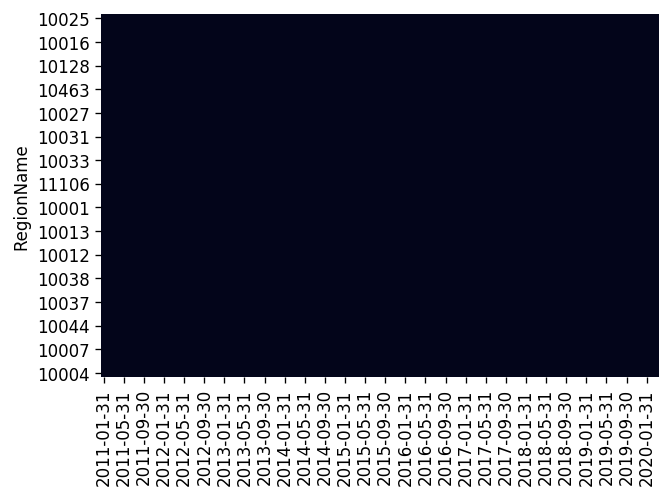

In [236]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
sns.heatmap(zillow_manhattan_data.isnull(), cbar=False)

In [235]:
zillow_manhattan_data = zillow_manhattan_data.dropna()

In [237]:
def get_change(ts_data):
    ts = ts_data.T
    ts_pre = ts.shift()
    return(((ts-ts_pre)/ts_pre).iloc[1:,:].T)

change = get_change(zillow_manhattan_data)

In [286]:
change.shape

(46, 110)

In [5]:
from sklearn.cluster import KMeans
from collections import defaultdict

In [240]:
kmeans = KMeans(n_init=40)

In [283]:
def plot_inertia(km, X, n_cluster_range):
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
#    plt.plot(n_cluster_range, inertias, marker='o')    
    plt.plot(n_cluster_range[1:], [inertias[i+1]-inertias[i] for i in range(len(inertias)-1)], marker='o')
    plt.title('Elbow method')
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.show()

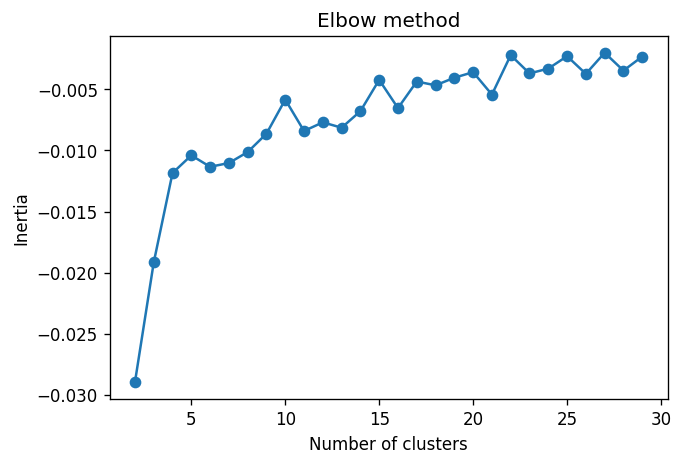

In [284]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
plot_inertia(kmeans, change, range(1, 30))

In [338]:
ngroup = 10

def fit_kmeans(ngroup,ts_data):
    kmeans = KMeans(ngroup, n_init=40)
    kmeans.fit(ts_data)

    cluster_groups = kmeans.predict(ts_data)

    similar_by_cluster = defaultdict(list)
    for a, b in zip(cluster_groups, zillow_manhattan_data.index):
           similar_by_cluster[a].append(b)

    for key,value in similar_by_cluster.items():
        print(f'Group {key}: {len(value)}')
        
    return(cluster_groups, similar_by_cluster)

cluster_groups, similar_by_cluster = fit_kmeans(ngroup, change)

Group 7: 2
Group 2: 15
Group 8: 2
Group 1: 15
Group 3: 1
Group 6: 2
Group 5: 3
Group 4: 2
Group 0: 3
Group 9: 1


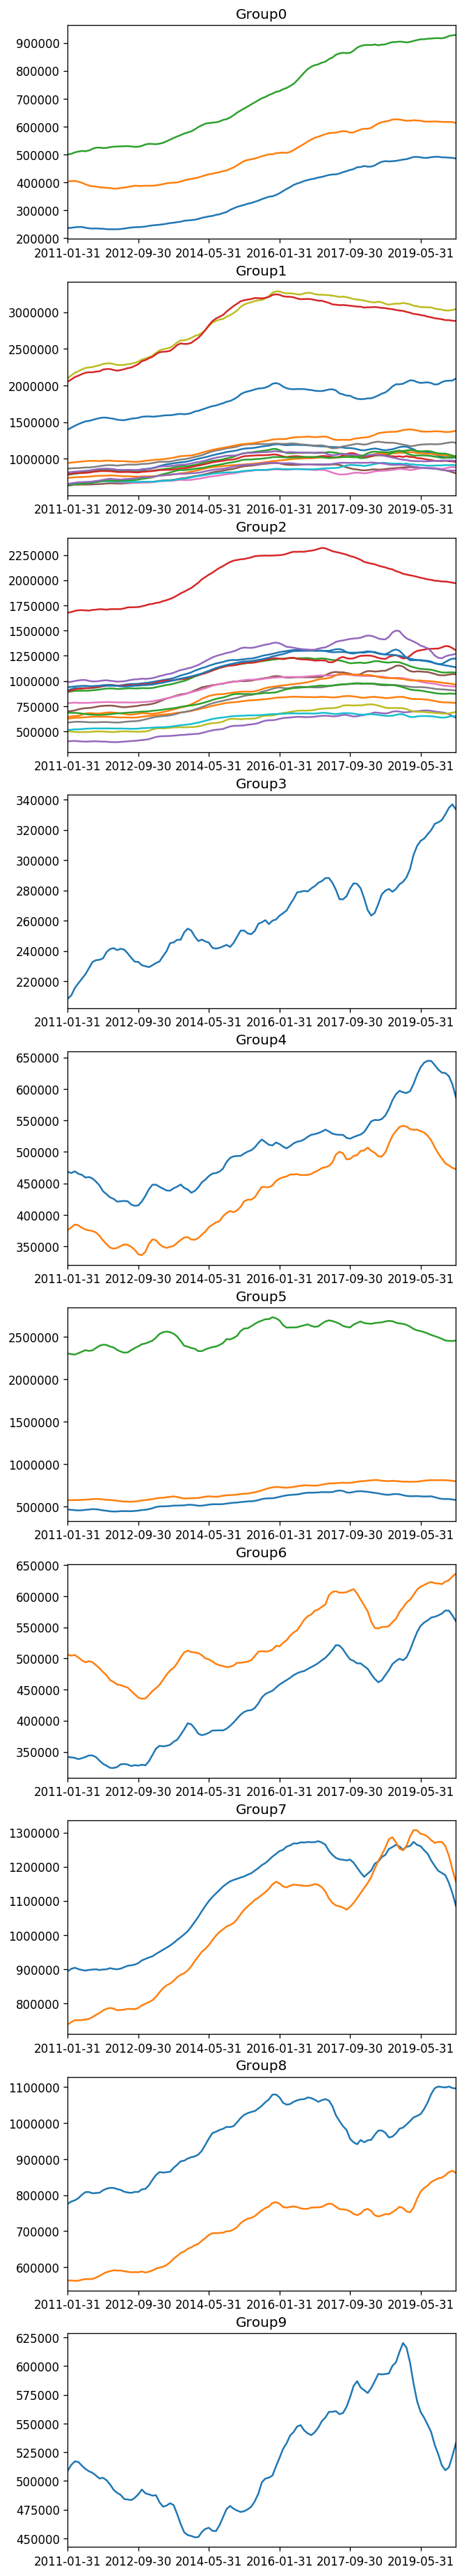

In [339]:
plt.rcParams.update({'figure.figsize':(6,4*ngroup), 'figure.dpi':120})
fig, axes = plt.subplots(ngroup, 1)
for g in range(ngroup):
    for zipcode in similar_by_cluster[g]:
        zillow_manhattan_data[zillow_manhattan_data.index==zipcode].T.plot(ax=axes[g])
        axes[g].set_title('Group'+str(g))
        axes[g].legend().set_visible(False)

In [340]:
kmeans_group = pd.DataFrame({'ZipCode':zillow_manhattan_data.index,'Group':cluster_groups})
# kmeans_group.to_csv('../data/kmeans_group.csv')

In [342]:
import folium

In [21]:
ny_geo_all = f'../data/nyu-2451-34509-geojson.json'

m_kmeans = folium.Map(location=[40.730610, -73.935242],zoom_start=11)

folium.Choropleth(
    geo_data=ny_geo_all,
    name='choropleth',
    data=kmeans_group,
    columns=['ZipCode', 'Group'],
    key_on='feature.properties.zcta', # Use 'feature', not 'features'. this seems to be a bug
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    bins = np.arange(ngroup+1),
    legend_name='K-Means Group'
).add_to(m_kmeans)

folium.LayerControl().add_to(m_kmeans)

# m_kmeans

NameError: name 'kmeans_group' is not defined

In [259]:
from scipy.cluster.hierarchy import dendrogram, linkage

In [352]:
hierarchy = linkage(change, method='ward')

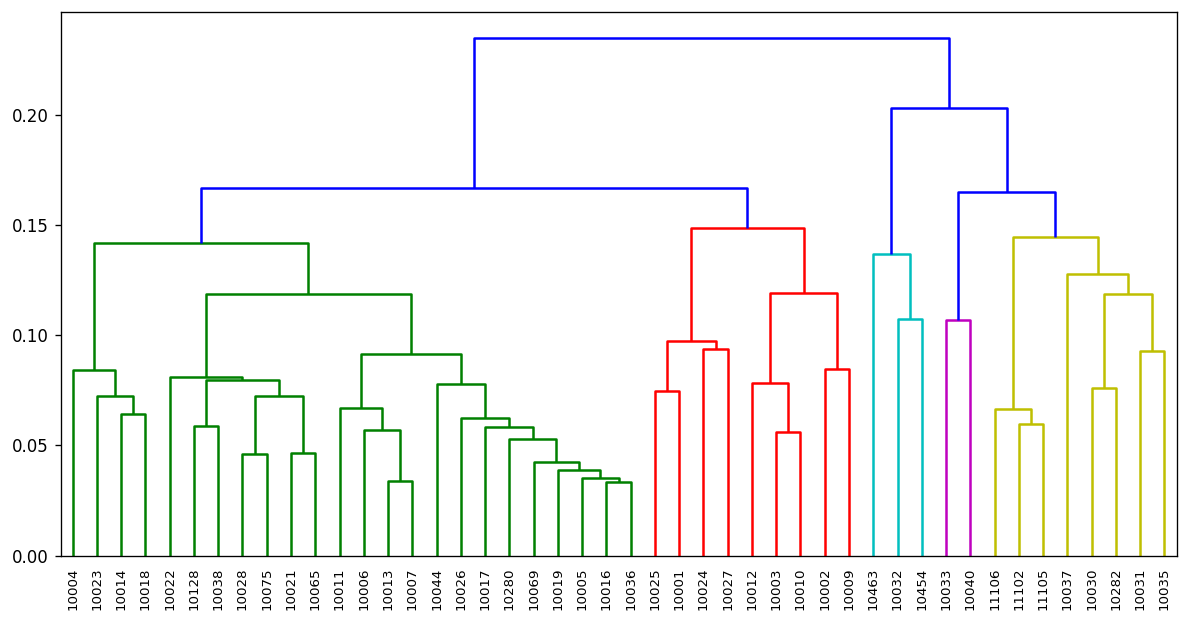

In [353]:
plt.figure(figsize=(12,6))
ans = dendrogram(hierarchy, labels=change.index)

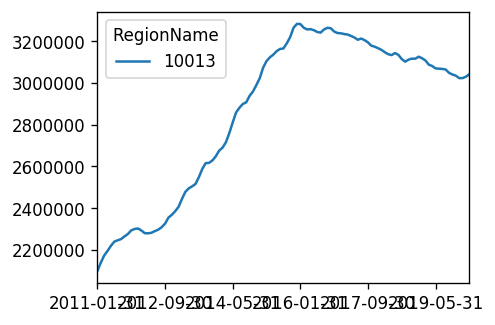

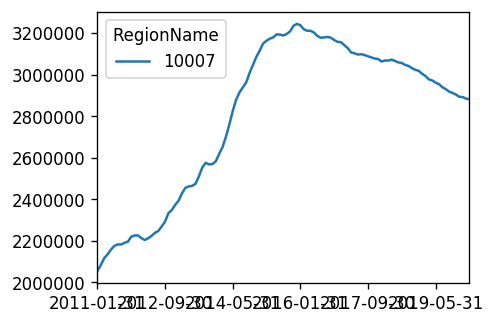

In [351]:
plt.rcParams.update({'figure.figsize':(4,3), 'figure.dpi':120})
zillow_manhattan_data[zillow_manhattan_data.index == '10013'].T.plot()
zillow_manhattan_data[zillow_manhattan_data.index == '10007'].T.plot()

### Zillow New York Metro

In [6]:
nymetro = Zip_Zhvi_AllHomes[Zip_Zhvi_AllHomes['Metro'] == 'New York-Newark-Jersey City'].copy()
nymetro_info = nymetro.iloc[:,:9].set_index('RegionName')
nymetro_data = pd.concat([nymetro['RegionName'],
                          nymetro.iloc[:,-3-12*9:]],axis=1).set_index('RegionName')

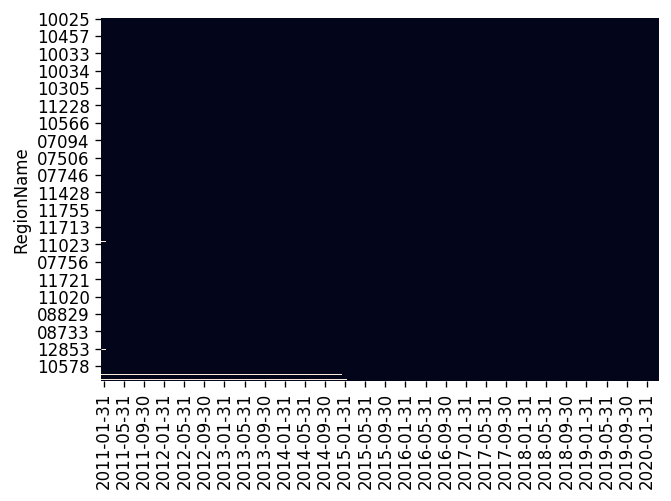

In [445]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
sns.heatmap(nymetro_data.isnull(), cbar=False)

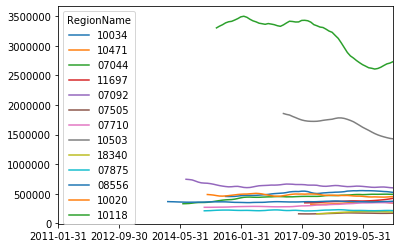

In [7]:
nymetro_data[nymetro_data.isna().mean(axis=1) >= 0.2].T.plot()

In [8]:
good = nymetro_data.isna().mean(axis=1) <= 0.2
nymetro_info = nymetro_info[good]
nymetro_data = nymetro_data[good]
nymetro_data = nymetro_data.interpolate(method='linear',limit_direction='both', axis=1)

In [9]:
nymetro_info.groupby('CountyName').count().sort_values('City',ascending=False)

,RegionID,SizeRank,RegionType,StateName,State,City,Metro
CountyName,,,,,,,
Suffolk County,106,106,106,106,106,106,106
Westchester County,74,74,74,74,74,74,74
Nassau County,67,67,67,67,67,67,67
Bergen County,65,65,65,65,65,65,65
Queens County,54,54,54,54,54,54,54
Monmouth County,50,50,50,50,50,50,50
Morris County,48,48,48,48,48,48,48
New York County,46,46,46,46,46,46,46
Orange County,45,45,45,45,45,45,45


In [10]:
def get_change(ts_data):
    ts = ts_data.T
    ts_pre = ts.shift()
    return(((ts-ts_pre)/ts_pre).iloc[1:,:].T)

nymetro_change = get_change(nymetro_data)

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'

In [11]:
nymetro_kmeans = KMeans(n_init=40)

In [12]:

def plot_inertia(km, X, n_cluster_range):
    plt.rcParams.update({'figure.figsize':(12,4), 'figure.dpi':120})
    fig, axes = plt.subplots(1,2)
    inertias = []
    for i in n_cluster_range:
        km.set_params(n_clusters=i)
        km.fit(X)
        inertias.append(km.inertia_)
    axes[0].plot(n_cluster_range, inertias, marker='o') 
#    plt.plot(n_cluster_range[1:], [inertias[i+1]-inertias[i] for i in range(len(inertias)-1)], marker='o')

#     zillow_manhattan_data[zillow_manhattan_data.index==zipcode].T.plot(ax=axes[g])
#     axes[g].set_title('Group'+str(g))
#     axes[g].legend().set_visible(False)
    
    axes[1].plot(n_cluster_range[1:], [inertias[i+1]-inertias[i] for i in range(len(inertias)-1)], 
             marker='o')
    

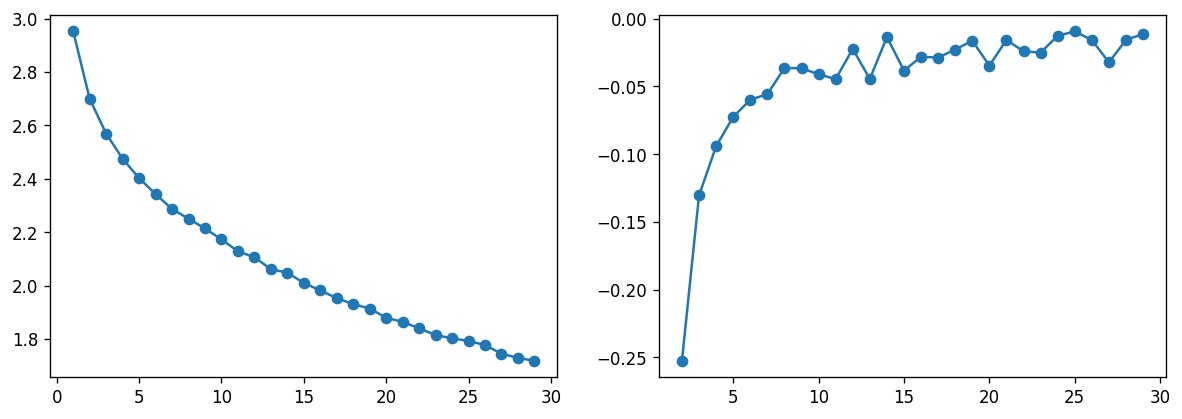

In [13]:
plt.rcParams.update({'figure.figsize':(6,4), 'figure.dpi':120})
plot_inertia(nymetro_kmeans, nymetro_change, range(1, 30))

In [22]:
ngroup = 8

def fit_kmeans(ngroup,ts_data):
    kmeans = KMeans(ngroup, n_init=40)
    kmeans.fit(ts_data)

    cluster_groups = kmeans.predict(ts_data)

    similar_by_cluster = defaultdict(list)
    for a, b in zip(cluster_groups, ts_data.index):
           similar_by_cluster[a].append(b)

    for key,value in similar_by_cluster.items():
        print(f'Group {key}: {len(value)}')
        
    return(cluster_groups, similar_by_cluster)

cluster_groups, similar_by_cluster = fit_kmeans(ngroup, nymetro_change)

Group 0: 75
Group 7: 21
Group 3: 153
Group 5: 164
Group 6: 211
Group 1: 163
Group 4: 40
Group 2: 99


In [455]:
def plot_ts(ts_data,ngroup,similar_by_cluster):
    plt.rcParams.update({'figure.figsize':(6,4*ngroup), 'figure.dpi':120})
    fig, axes = plt.subplots(ngroup, 1)
    for g in range(ngroup):
        for zipcode in similar_by_cluster[g]:
            ts_data[ts_data.index==zipcode].T.plot(ax=axes[g])
            axes[g].set_title('Group'+str(g))
            axes[g].legend().set_visible(False)
            
# plot_ts(nymetro_data,ngroup,similar_by_cluster)

In [23]:
nymetro_kmeans_group = pd.DataFrame({'ZipCode':nymetro_data.index,'Group':cluster_groups})

In [1]:
import json

with open('../data/ny_new_york_zip_codes_geo.min.json','r') as jsonFile:
    ny_geo = json.load(jsonFile)
with open('../data/nj_new_jersey_zip_codes_geo.min.json','r') as jsonFile:
    nj_geo = json.load(jsonFile)
with open('../data/pa_pennsylvania_zip_codes_geo.min.json','r') as jsonFile:
    pa_geo = json.load(jsonFile)
    
list_geo = []  

def add_state(metro,state):
    for i in range(len(state['features'])):
        metro.append(state['features'][i])

add_state(list_geo,ny_geo)
add_state(list_geo,nj_geo)
add_state(list_geo,pa_geo)

nymetro_geo = dict.fromkeys(['type', 'features'])
nymetro_geo['type'] = 'FeatureCollection'
nymetro_geo['features'] = list_geo

# open('../data/nymetro_zip_codes_geo.min.json','w').write(
#     json.dumps(nymetro_geo,sort_keys=False,indent=4,separators=(',',':'))
# )
# Size is way too large than individual files combined, why??

In [5]:
len(nymetro_geo['features'])

4187

In [47]:
# nymetro_geo = f'../data/nymetro_zip_codes_geo.min.json'

nymetro_map = folium.Map(location=[40.730610, -73.935242],zoom_start=8)

folium.Choropleth(
    geo_data=nymetro_geo,
    data=nymetro_kmeans_group,
    bins = np.arange(ngroup+1),
    name='choropleth',
    columns=['ZipCode', 'Group'],
    key_on='feature.properties.ZCTA5CE10', # Use 'feature', not 'features'. this seems to be a bug
    fill_color='RdBu',
    fill_opacity=0.7,
    line_opacity=0.2,
    nan_fill_opacity = 0,
    legend_name='Submarket'
).add_to(nymetro_map)

folium.LayerControl().add_to(nymetro_map)

nymetro_map.save('../fig/nymetro_map_8.html')